# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

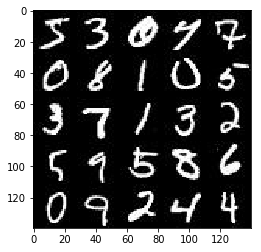

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

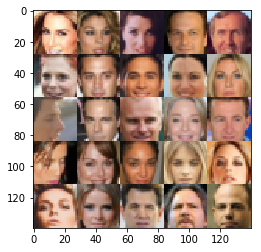

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
import collections

Shape = collections.namedtuple('Shape', ('width', 'height', 'depth'))

# Shapes (just for information)
mnist_shape = Shape(28, 28, 1)
celeba_shape = Shape(28, 28, 3)

In [7]:
import functools
import operator

def flatten_size(shape):
    """Calculates flatten size by Shape"""
    return functools.reduce(operator.mul, shape)

def flatten(x, conv_shape):
    """Converts convolutional layer to dense layer"""
    return tf.reshape(x, (-1, flatten_size(conv_shape)))                    

def leaky_relu(x, alpha):
    return tf.maximum(alpha * x, x)

DISCRIMINATOR_VAR_SCOPE = 'discriminator'


def convout(input_tensor, alpha, training, normalization=True, dropout=None):
    if normalization:
        input_tensor = tf.layers.batch_normalization(input_tensor, training=training)
    relu = leaky_relu(input_tensor, alpha)
    if dropout:
        out = tf.layers.dropout(relu, dropout, training=training)
    else:
        out = relu
    return out

                      
def discriminator(images, reuse=False, alpha=0.2, rate=0.1, kernel_size=3):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d
    
    with tf.variable_scope(DISCRIMINATOR_VAR_SCOPE, reuse=reuse):
        # Input layer is 28x28x1 or 28x28x3
        
        x1 = tf.layers.conv2d(images, 128, kernel_size, strides=2, padding='same', kernel_initializer=kernel_initializer())
        out1 = convout(x1, alpha, training=True, normalization=False, dropout=rate)
        # 16x16x128 now
                
        x2 = tf.layers.conv2d(out1, 256, kernel_size, strides=2, padding='same', kernel_initializer=kernel_initializer())
        out2 = convout(x2, alpha, training=True, normalization=True, dropout=rate)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d(out2, 512, kernel_size, strides=2, padding='same', kernel_initializer=kernel_initializer())
        out3 = convout(x3, alpha, training=True, normalization=True, dropout=rate)
        # 4x4x512 now

        out3_shape = Shape(*[int(dimension) for dimension in out3.shape[1:]])
        
        # Flatten it
        flat = flatten(out3, out3_shape)
        
        logits = tf.layers.dense(flat, 1, kernel_initializer=kernel_initializer())
        
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def start_convolutional(x, shape, kernel_initializer):
    """Starts convolutional stack
    
    shape is a Shape object
    """
    y = tf.layers.dense(x, flatten_size(shape), kernel_initializer=kernel_initializer)
    # Reshape y to start the convolutional stack
    y = tf.reshape(y, (-1, shape.width, shape.height, shape.depth))
    return y

GENERATOR_VAR_SCOPE = 'generator'

def generator(z, out_channel_dim, is_train=True, alpha=0.2, rate=0.1, kernel_size=5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d
    
    with tf.variable_scope(GENERATOR_VAR_SCOPE, reuse=not is_train):

        x0 = start_convolutional(z, Shape(7, 7, 512), kernel_initializer())
        out0 = convout(x0, alpha, training=is_train, normalization=True, dropout=rate)
        # 7x7x512 now
        
        x1 = tf.layers.conv2d_transpose(out0, 256, kernel_size, strides=1, padding='same',
                                        kernel_initializer=kernel_initializer())
        out1 = convout(x1, alpha, training=is_train, normalization=True, dropout=rate)
        # 14x14x256 now
        
        x2 = tf.layers.conv2d_transpose(out1, 128, kernel_size, strides=2, padding='same',
                                        kernel_initializer=kernel_initializer())
        out2 = convout(x2, alpha, training=is_train, normalization=True, dropout=rate)
        # 28x28x128 now
        
        logits = tf.layers.conv2d_transpose(out2, out_channel_dim, kernel_size, strides=2, padding='same',
                                            kernel_initializer=kernel_initializer())
        # 28x28x<out>
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def one_sided_smoothing(out, k):
    return tf.ones_like(out) * (1 - k)

def uniform_smoothing(out, from_, to):
    return tf.random_uniform(tf.shape(out), from_, to, tf.float32)

def model_loss(input_real, input_z, out_channel_dim, alpha=0.2,
               label_smoothness=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_out = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_real_out, d_real_logits = discriminator(input_real, reuse=False, alpha=alpha)
    d_fake_out, d_fake_logits = discriminator(g_out, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_real_logits, 
            labels=uniform_smoothing(d_real_out, 0.7, 1.2)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_fake_logits, 
            labels=uniform_smoothing(d_fake_out, 0.0, 0.3)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_fake_logits, 
            labels=tf.ones_like(d_fake_out)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith(DISCRIMINATOR_VAR_SCOPE)]
    g_vars = [var for var in t_vars if var.name.startswith(GENERATOR_VAR_SCOPE)]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          alpha=0.2,
          print_every=10, show_every=50, show_images=25):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape      
    
    # Build model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # let's go
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                # images normalization [-1, 1]
                batch_images = batch_images * 2
                
                # white noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt,
                             feed_dict={input_z: batch_z,
                                        input_real: batch_images,
                                        lr: learning_rate})
                _ = sess.run(g_opt, 
                             feed_dict={input_z: batch_z, 
                                        input_real: batch_images,
                                        lr: learning_rate})
                                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    #Print the current image
                    show_generator_output(sess, show_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.6911
Epoch 1/2... Discriminator Loss: 2.5795... Generator Loss: 0.1279
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 0.5747
Epoch 1/2... Discriminator Loss: 2.0989... Generator Loss: 0.1709
Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 1.9049


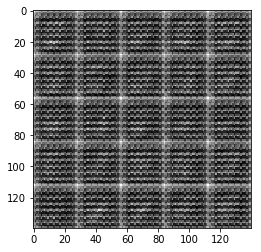

Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 0.5328
Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.6882
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 1.0474
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 0.8896


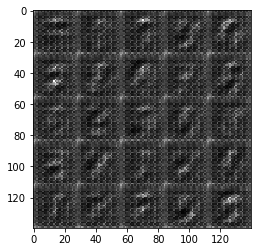

Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 0.8629
Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 1.9693
Epoch 1/2... Discriminator Loss: 1.4980... Generator Loss: 0.5140
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.5151


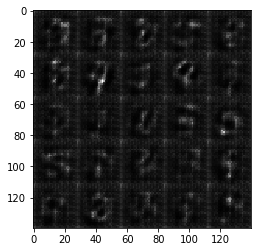

Epoch 1/2... Discriminator Loss: 1.3283... Generator Loss: 0.7177
Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 0.4529
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 0.5156
Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 0.9564


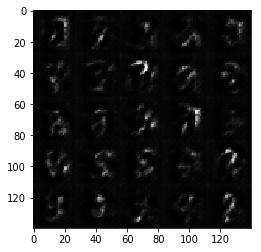

Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.9564
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 0.9484
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 1.3497
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.6232
Epoch 1/2... Discriminator Loss: 1.1524... Generator Loss: 0.6749


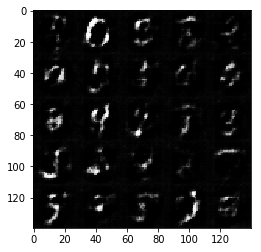

Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 1.5185
Epoch 1/2... Discriminator Loss: 1.1524... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 0.5958
Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 0.6365
Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 1.1979


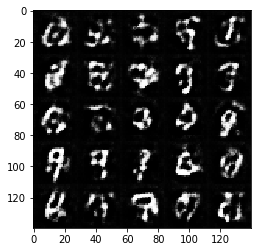

Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 1.0262
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 1.0515
Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 0.6962


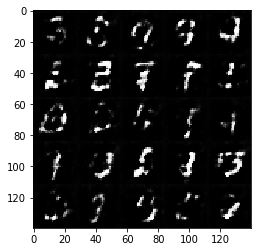

Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 0.6151
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 0.6627
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 0.7230
Epoch 1/2... Discriminator Loss: 1.1574... Generator Loss: 0.8214


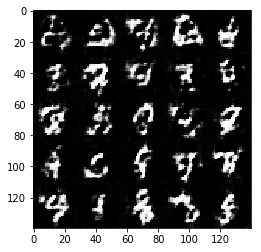

Epoch 1/2... Discriminator Loss: 1.0537... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 1.2220
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.8588
Epoch 1/2... Discriminator Loss: 1.1194... Generator Loss: 0.9811
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 0.9919


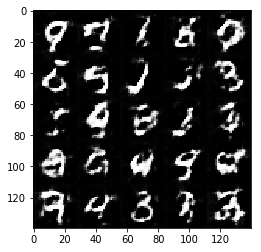

Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 1.4139
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 0.8623
Epoch 1/2... Discriminator Loss: 0.9929... Generator Loss: 1.0218
Epoch 1/2... Discriminator Loss: 1.1030... Generator Loss: 1.0912
Epoch 1/2... Discriminator Loss: 1.0247... Generator Loss: 0.8004


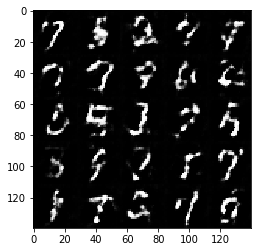

Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 1.0134
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 0.9299
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 1.3780
Epoch 1/2... Discriminator Loss: 1.0377... Generator Loss: 1.0620
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 0.8792


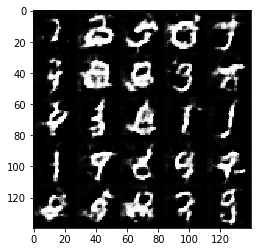

Epoch 1/2... Discriminator Loss: 1.0932... Generator Loss: 0.8880
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.4389
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 0.6380
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 1.1373
Epoch 1/2... Discriminator Loss: 1.0742... Generator Loss: 0.6950


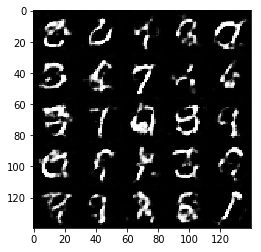

Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 0.4874
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.8564
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.6924
Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 1.7537
Epoch 1/2... Discriminator Loss: 1.1924... Generator Loss: 0.7992


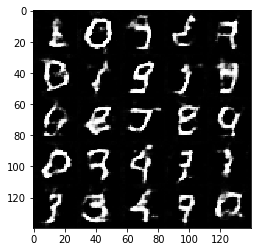

Epoch 1/2... Discriminator Loss: 1.0908... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.6828
Epoch 1/2... Discriminator Loss: 1.0365... Generator Loss: 0.8715
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 0.9296


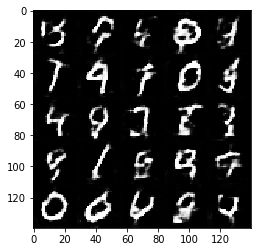

Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.4441
Epoch 1/2... Discriminator Loss: 1.1685... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 0.9476
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.8274


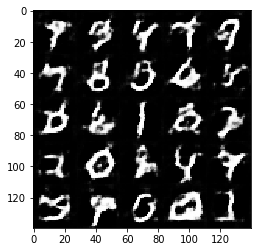

Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 0.9764
Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.5410
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.4904
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 0.9518


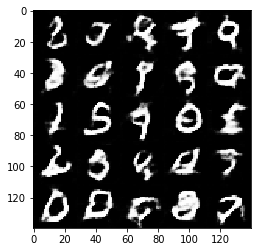

Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 1.0488
Epoch 1/2... Discriminator Loss: 0.9904... Generator Loss: 0.8756
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 1.2535
Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 0.9562... Generator Loss: 1.1776


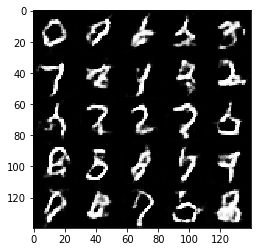

Epoch 1/2... Discriminator Loss: 1.7168... Generator Loss: 0.2887
Epoch 1/2... Discriminator Loss: 1.3074... Generator Loss: 0.9255
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 1.1519
Epoch 1/2... Discriminator Loss: 1.1337... Generator Loss: 0.5357
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 0.7883


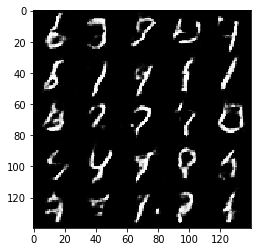

Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 0.6579
Epoch 1/2... Discriminator Loss: 1.5310... Generator Loss: 0.3022
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 0.9897... Generator Loss: 1.0445
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.9036


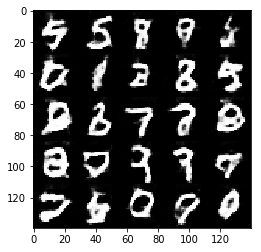

Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 1.0721
Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 1.0369
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.5662
Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 0.8168
Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 2.0937


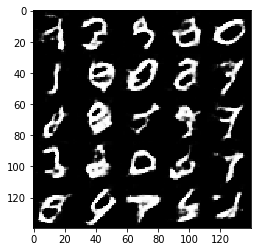

Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 1.0050
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 1.2219
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.0537
Epoch 2/2... Discriminator Loss: 1.0123... Generator Loss: 0.7139
Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 1.1037


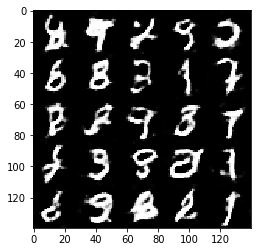

Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 0.4012
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 1.4861
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 1.1279
Epoch 2/2... Discriminator Loss: 0.9526... Generator Loss: 0.8697
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 0.4320


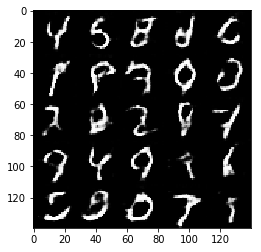

Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 2.0556
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 0.9493
Epoch 2/2... Discriminator Loss: 0.9893... Generator Loss: 0.6430
Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 1.5752... Generator Loss: 0.5615


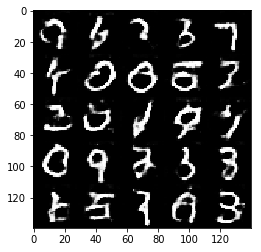

Epoch 2/2... Discriminator Loss: 1.0159... Generator Loss: 1.4016
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 0.7519
Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.5955
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 0.9092
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 0.7860


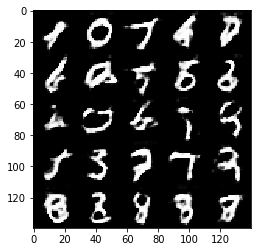

Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 1.2644
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 0.9818
Epoch 2/2... Discriminator Loss: 1.1298... Generator Loss: 0.7781
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 0.6734
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.8516


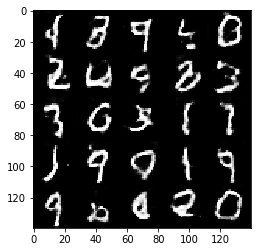

Epoch 2/2... Discriminator Loss: 1.7819... Generator Loss: 2.2328
Epoch 2/2... Discriminator Loss: 1.2115... Generator Loss: 0.5242
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 0.8933
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 0.9027


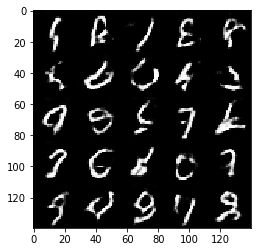

Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 0.9874
Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 0.7804
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 0.9009
Epoch 2/2... Discriminator Loss: 0.9893... Generator Loss: 1.8470
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 1.0348


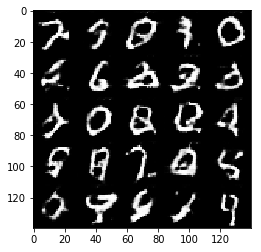

Epoch 2/2... Discriminator Loss: 1.1093... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.0140
Epoch 2/2... Discriminator Loss: 0.9783... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 0.7996... Generator Loss: 1.2644
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 1.5748


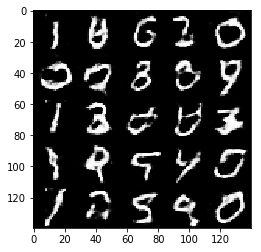

Epoch 2/2... Discriminator Loss: 1.1432... Generator Loss: 1.3186
Epoch 2/2... Discriminator Loss: 1.5601... Generator Loss: 1.5398
Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 0.5162
Epoch 2/2... Discriminator Loss: 0.8839... Generator Loss: 1.1316
Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 0.6545


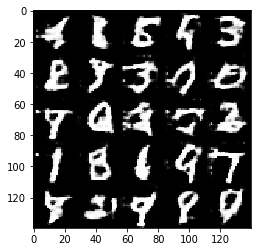

Epoch 2/2... Discriminator Loss: 0.8613... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 0.8665... Generator Loss: 1.0115
Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.1242


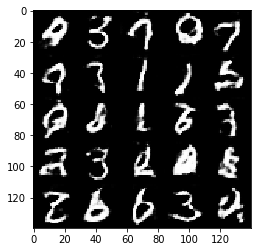

Epoch 2/2... Discriminator Loss: 0.8746... Generator Loss: 1.3452
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 0.9023
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 1.3382
Epoch 2/2... Discriminator Loss: 0.8715... Generator Loss: 1.1421
Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 0.8490


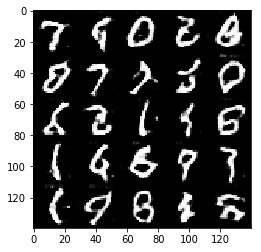

Epoch 2/2... Discriminator Loss: 0.8384... Generator Loss: 1.4047
Epoch 2/2... Discriminator Loss: 1.0949... Generator Loss: 0.5641
Epoch 2/2... Discriminator Loss: 1.0638... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 0.8493
Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 0.8617


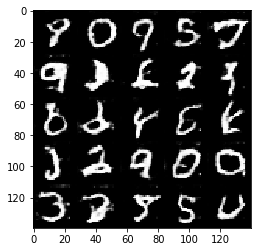

Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 0.8396
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 1.3952
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.8463
Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 1.4222
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 0.8892


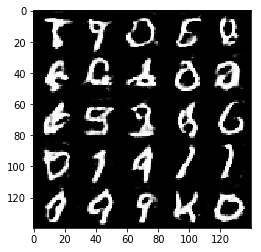

Epoch 2/2... Discriminator Loss: 0.9011... Generator Loss: 1.0208
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 0.9601... Generator Loss: 1.0359
Epoch 2/2... Discriminator Loss: 0.9938... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 0.7968


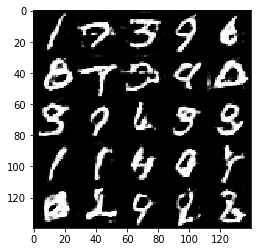

Epoch 2/2... Discriminator Loss: 1.3261... Generator Loss: 0.5375
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.5840
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 0.6834
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 1.0206
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 1.3175


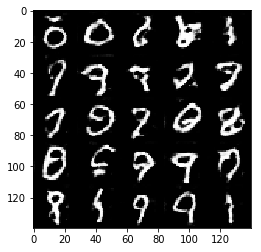

Epoch 2/2... Discriminator Loss: 0.8000... Generator Loss: 1.3997
Epoch 2/2... Discriminator Loss: 0.8661... Generator Loss: 1.0897
Epoch 2/2... Discriminator Loss: 0.8227... Generator Loss: 1.4022
Epoch 2/2... Discriminator Loss: 0.7427... Generator Loss: 1.3490
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.6701


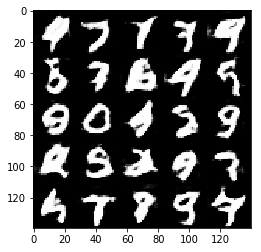

Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 2.6266
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 0.8477
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 0.7236


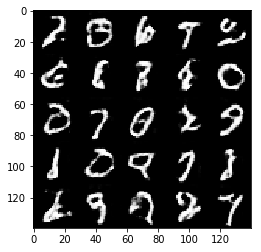

Epoch 2/2... Discriminator Loss: 0.9744... Generator Loss: 0.8421
Epoch 2/2... Discriminator Loss: 0.8992... Generator Loss: 1.0106


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
alpha = 0.2
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.4217
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 4.1805
Epoch 1/1... Discriminator Loss: 2.2720... Generator Loss: 0.1531
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.6630


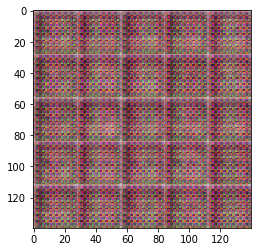

Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.7064
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 3.5978
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 0.7809


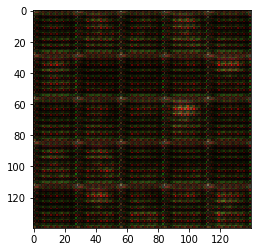

Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.2712
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.4650


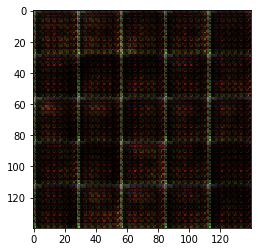

Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.4239
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.6013... Generator Loss: 0.2777
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 1.1483


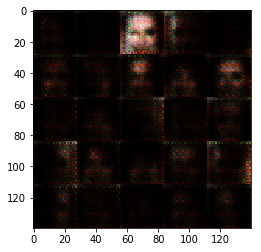

Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.1893
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 1.8727


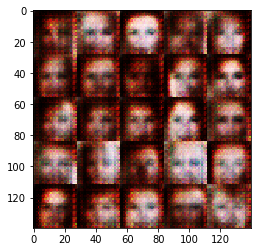

Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.4135
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 1.7225... Generator Loss: 0.3694
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.2393


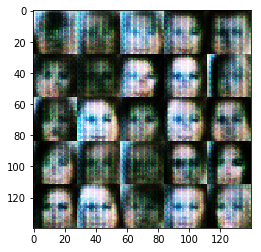

Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 2.2145
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.7312
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.3944


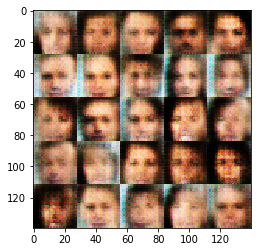

Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 1.5612
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 2.1655
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.6215


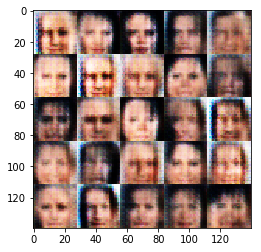

Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.4316
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 2.0778
Epoch 1/1... Discriminator Loss: 0.8505... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 2.3303


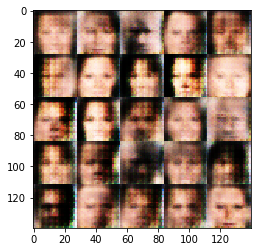

Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.4696
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 1.6477


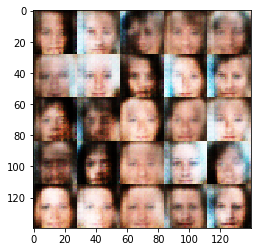

Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 2.0348


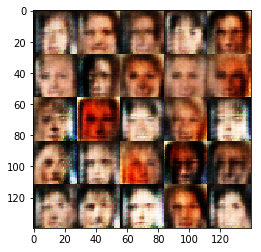

Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.4523
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.6001
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.4131
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 1.0313


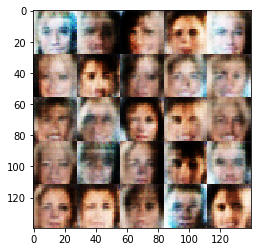

Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.3714
Epoch 1/1... Discriminator Loss: 1.7734... Generator Loss: 0.2539
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 1.4342
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 1.6650
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.5173


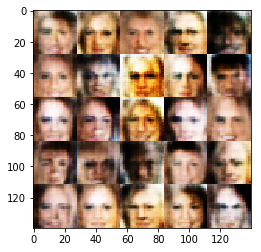

Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 1.7342
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.6865


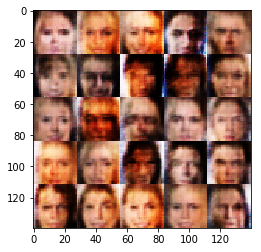

Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.2407
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 1.5669
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9555


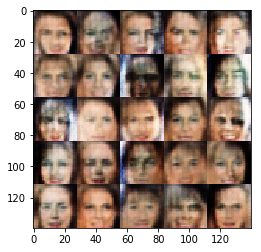

Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.7014


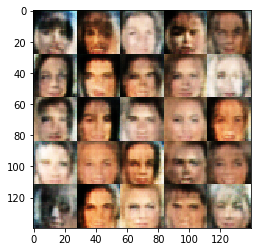

Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.8878


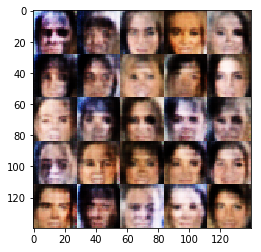

Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 1.7678
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 1.4129
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.5010


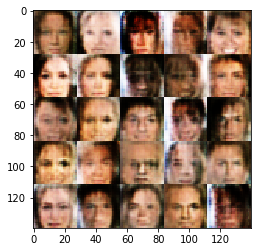

Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.9293


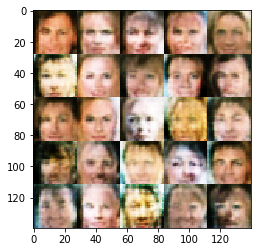

Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.4676
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 1.3992


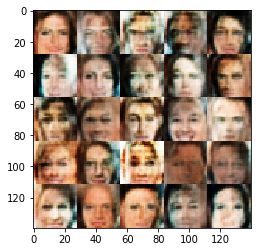

Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.9008


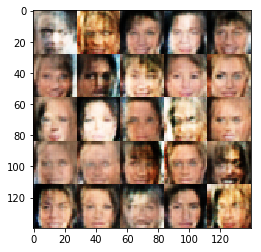

Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.6904


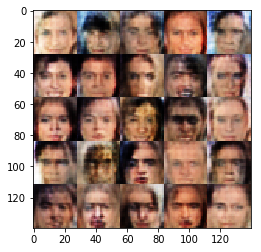

Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.9003


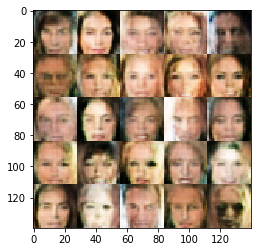

Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.4904


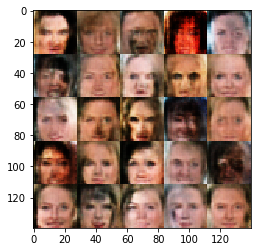

Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.7509


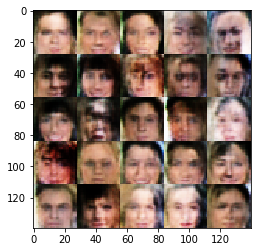

Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 1.2438
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.5612
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.4518


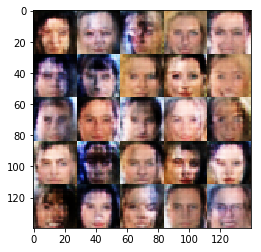

Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.7502


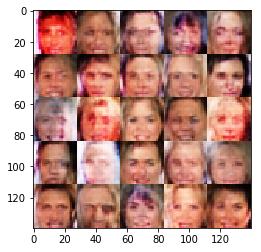

Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7559


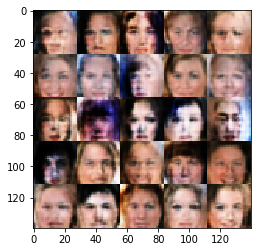

Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.6461


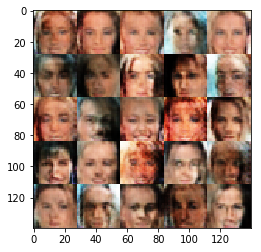

Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.7001


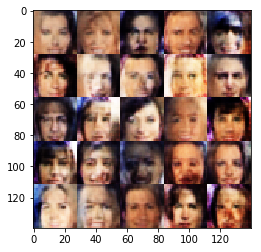

Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.9836


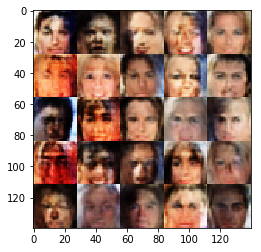

Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 1.0104


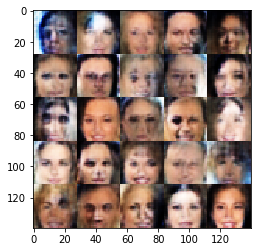

Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 1.1477


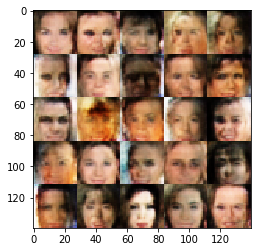

Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.6046


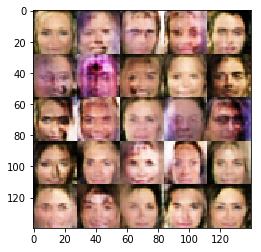

Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.0440


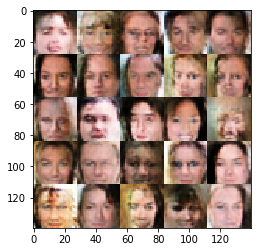

Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.6082


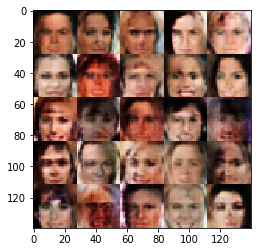

Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.7084


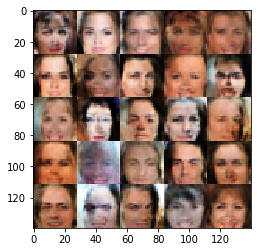

Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.0780


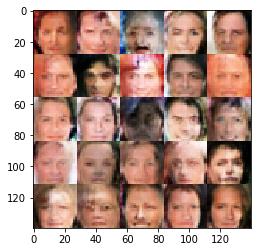

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.4014
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 1.0783


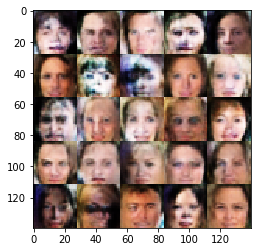

Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.4845


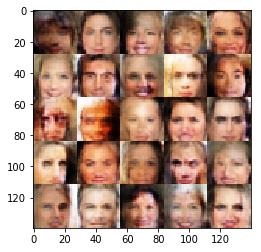

Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 1.0103


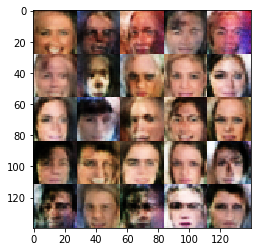

Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.1641


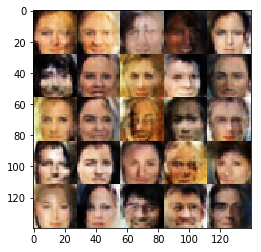

Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.3717
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 1.0250


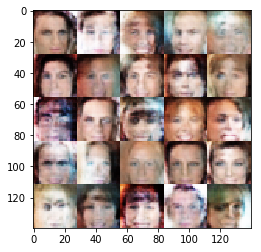

Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.9968


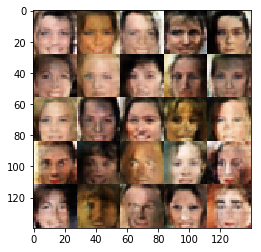

Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.8962


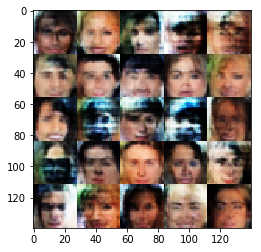

Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 1.0532
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.0308


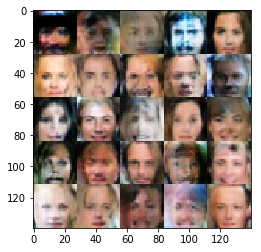

Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.8025


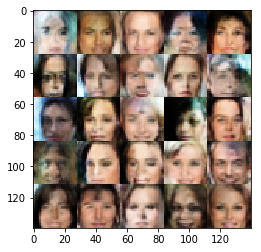

Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.5984


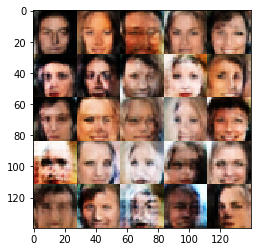

Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.2582


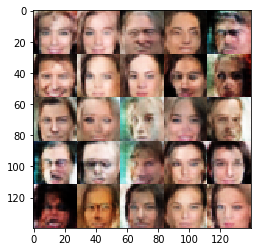

Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.7028


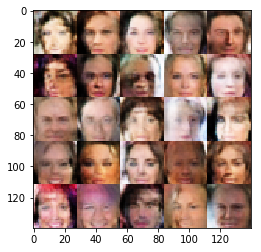

Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.4546


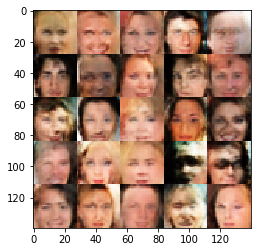

Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.4575
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.4646


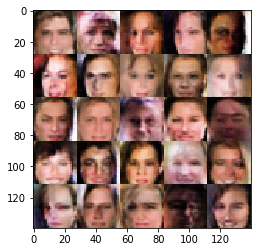

Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 1.1341
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.4399
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.5470


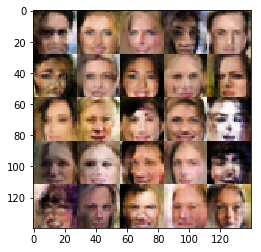

Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.5699


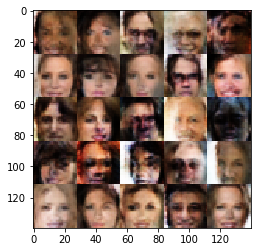

Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.4510
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.6883


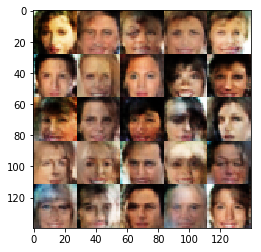

Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.2502


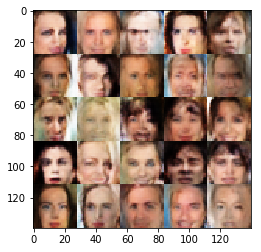

Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.9422


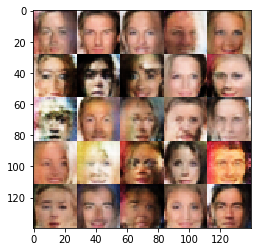

Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.5098
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.8754


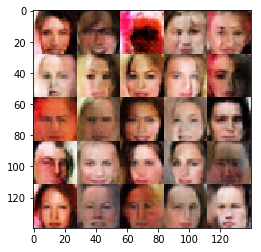

Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.6903


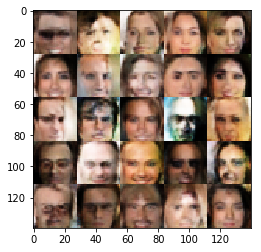

Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.5912


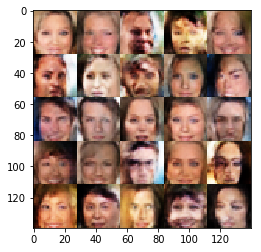

Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.9977


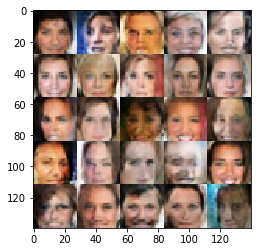

Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.5457


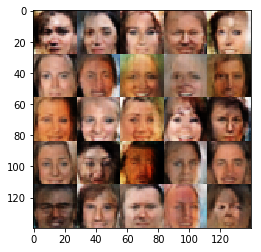

Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.9658


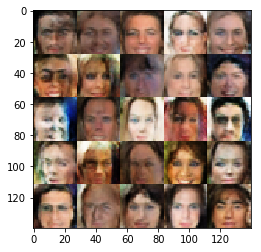

Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 0.9119


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
alpha = 0.2
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha=alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.